# Solving Reacher Environment Using DDPG Agent

---

## Introduction

In this project, we will create an agent to reach the green balooon. The agent is in form of a robotic arm which have a freedom to move in all direction. The term agent here is a robot built using Artificial Intelligence. In detail, we use Deep Deterministic Policy Gradient(DDPG) well-written in [this paper](https://arxiv.org/abs/1509.02971).

Keep in mind, our goal is move the agent's hand to touch the target baloon. A reward of +0.1 is provided for each step that the agent's hand is in the baloon location. Thus, the goal of your agent is to maintain its position at the target baloon for as many time steps as possible.

Please follow the instructions below to train and run the agent!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [28]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1599999964237213


When finished, you can close the environment.

In [6]:
env.close()

### 4. Contruct the Train Method

Before designing our agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [5]:
from collections import deque
import torch

target_avg_score = 30.0

def train(agent, env, brain_name, num_agents, n_episodes=1000, max_t=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]        # reset the environment
        states = env_info.vector_observations                    # get the current state (for each agent)
        episode_scores = np.zeros(num_agents)                    # initialize the score (for each agent)
        agent.reset()                                            # initialize the agent
        for t in range(max_t):
            actions = agent.act(states)                          # select an action (for each agent)
            env_info = env.step(actions)[brain_name]             # send all actions to tne environment
            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = env_info.rewards                           # get reward (for each agent)
            dones = env_info.local_done                          # see if episode finished
            agent.step(states, actions, rewards, next_states, dones) # agent take learning step
            episode_scores += np.array(rewards)                           # update the score (for each agent)
            states = next_states                                  # roll over states to next time step
            if np.any(dones):
                break 
        episode_score = np.mean(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if np.mean(scores_deque) >= target_avg_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
    return scores


import signal
from contextlib import contextmanager
import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

### 5. Train The Agent
Now you can train the agent by executing the following cell.

Episode 100	Average Score: 9.49
Episode 167	Average Score: 30.04
Environment solved in 167 episodes!	Average Score: 30.04


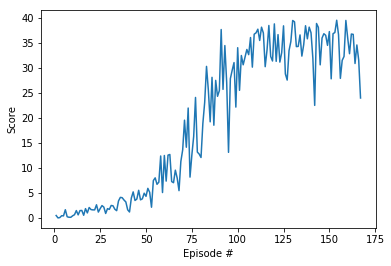

In [6]:
from src.agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)
with active_session():
    scores = train(agent, env, brain_name, num_agents)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Watch The Smart Agent Play
After training process, our agent will be smart enough to track and touch the target baloon. Keep an eye on the score which shows that our agent has been smart enough to get a good score.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
from src.agent import Agent

try: # Check if the env and agent has been initialized
    env
    agent
except: # if not, initialize tha env and agent
    # select this option to load version 1 (with a single agent) of the environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
    # select this option to load version 2 (with 20 agents) of the environment
    #env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    num_agents = len(env_info.agents)
    action_size = brain.vector_action_space_size
    states = env_info.vector_observations
    state_size = states.shape[1]
    agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

# The agent play the game
env_info = env.reset(train_mode=True)[brain_name]       # reset the environment    
states = env_info.vector_observations                   # get the current state (for each agent)
scores = np.zeros(num_agents)                           # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise=False)         # select an action (for each agent)
    env_info = env.step(actions)[brain_name]             # send all actions to tne environment
    next_states = env_info.vector_observations           # get next state (for each agent)
    rewards = env_info.rewards                           # get reward (for each agent)
    dones = env_info.local_done                          # see if episode finished
    scores += env_info.rewards                           # update the score (for each agent)
    states = next_states                                 # roll over states to next time step
    if np.any(dones):                                    # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Total score (averaged over agents) this episode: 36.48999918438494


In [3]:
# Close the environment when you finish using the above cell
env.close()